In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.util.operations import GetUniqueRows
from teslakit.storms import Extract_Circle_Nakajo, SortCategoryCount



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


In [3]:
# --------------------------------------
# load data and set parameters

xds_Nakajo = db.Load_TCs_Nakajo()  # Nakajo simulations

# wave point longitude and latitude
pnt_lon = 167.5
pnt_lat = 9.75

# radius for TCs selection (º)
r1 = 14
r2 = 4



## Synthetic TCs - Category Change Probabilities

In [4]:
# --------------------------------------
# Select Nakajo TCs inside circle

# dictionary with needed variable names
d_vns = {
    'longitude':'ylon_TC',
    'latitude':'ylat_TC',
    'pressure':'yCPRES',
}

# Extract TCs inside R=14 and positions
_, xds_in_r1 = Extract_Circle_Nakajo(xds_Nakajo, pnt_lon, pnt_lat, r1, d_vns)

# Extract TCs inside R=4 and positions
_, xds_in_r2 = Extract_Circle_Nakajo(xds_Nakajo, pnt_lon, pnt_lat, r2, d_vns)

print(xds_in_r1)
print()
print(xds_in_r2)


<xarray.Dataset>
Dimensions:       (storm: 63167)
Coordinates:
  * storm         (storm) int64 5 8 14 50 52 ... 999974 999982 999986 999990
Data variables:
    pressure_min  (storm) float64 983.2 932.8 960.5 978.9 ... 968.4 973.3 992.4
    category      (storm) int64 1 4 3 2 1 0 0 0 2 1 5 ... 0 4 1 2 1 1 4 0 2 2 1
Attributes:
    point_lon:  167.5
    point_lat:  9.75
    point_r:    14

<xarray.Dataset>
Dimensions:       (storm: 12840)
Coordinates:
  * storm         (storm) int64 5 296 299 387 ... 999846 999877 999982 999986
Data variables:
    pressure_min  (storm) float64 988.1 961.0 998.7 ... 976.4 1.007e+03 998.5
    category      (storm) int64 1 3 1 1 2 4 0 2 0 0 1 ... 3 1 2 3 2 1 1 0 2 0 1
Attributes:
    point_lon:  167.5
    point_lat:  9.75
    point_r:    4


In [5]:
# --------------------------------------
# Calculate Syntethic TCs category change probabilities

# Get storm category inside both circles
n_storms = len(xds_in_r1.storm)
categ_r1r2 = np.empty((n_storms, 2))
for i in range(len(xds_in_r1.storm)):

    # category inside R1
    storm_in_r1 = xds_in_r1.isel(storm=[i])
    storm_id = storm_in_r1.storm.values[0]
    storm_cat_r1 = storm_in_r1.category

    # category inside R2
    if storm_id in xds_in_r2.storm.values[:]:
        storm_in_r2 = xds_in_r2.sel(storm=[storm_id])
        storm_cat_r2 = storm_in_r2.category
    else:
        storm_cat_r2 = 9  # no category 

    # store categories
    categ_r1r2[i,:] = [storm_cat_r1, storm_cat_r2]


# count category changes and sort it
categ_count = GetUniqueRows(categ_r1r2)
categ_count = SortCategoryCount(categ_count)

# calculate probability
m_count = np.reshape(categ_count[:,2], (6,-1)).T
m_sum = np.sum(m_count,axis=0)

probs = m_count.astype(float)/m_sum.astype(float)
probs_cs = np.cumsum(probs, axis=0)

# store output using xarray
xds_categ_cp = xr.Dataset(
    {
        'category_change_count': (('category','category'), m_count[:-1,:]),
        'category_change_sum': (('category'), m_count[-1,:]),
        'category_change_probs': (('category','category'), probs[:-1,:]),
        'category_nochange_probs': (('category'), probs[-1,:]),
        'category_change_cumsum': (('category','category'), probs_cs[:-1,:]),
    },
    coords = {
        'category': [0,1,2,3,4,5]
    }
)
print(xds_categ_cp)

db.Save_TCs_probs_synth(xds_categ_cp)


<xarray.Dataset>
Dimensions:                  (category: 6)
Coordinates:
  * category                 (category) int64 0 1 2 3 4 5
Data variables:
    category_change_count    (category, category) int64 1811 1299 264 ... 0 990
    category_change_sum      (category) int64 20195 18556 3722 4182 1854 1818
    category_change_probs    (category, category) float64 0.0823 ... 0.2465
    category_nochange_probs  (category) float64 0.9177 0.8788 ... 0.4346 0.4527
    category_change_cumsum   (category, category) float64 0.0823 ... 0.5473


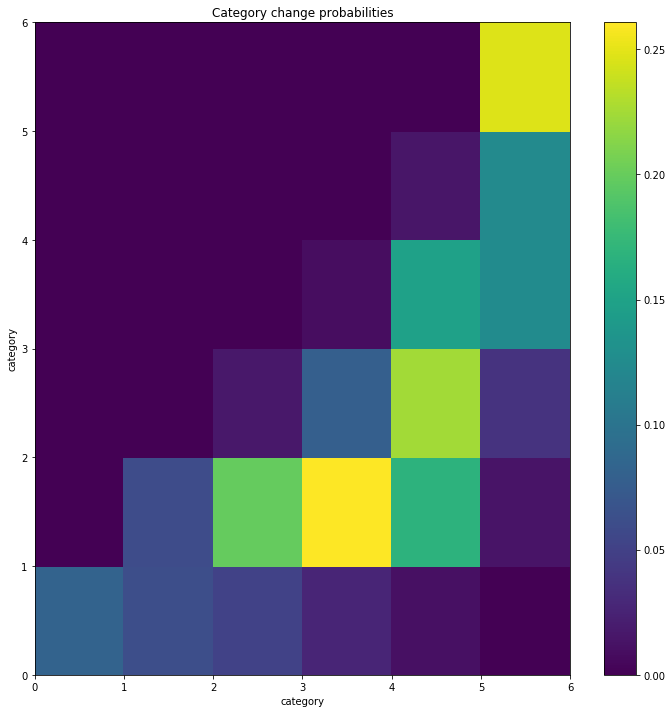

In [6]:
# plot category change probabilities

cp = xds_categ_cp.category_change_probs.values[:]
cs = xds_categ_cp.category.values[:]

fig, axes = plt.subplots(figsize=(12,12))
axes.set_title('Category change probabilities')
axes.set_xlabel('category')
axes.set_ylabel('category')
pc=axes.pcolor(cp)
fig.colorbar(pc)

plt.show()
